# Notebook for Project


In [2]:
import pandas as pd

df_= pd.read_csv('data/churn.csv')



In [3]:
df_.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


<Axes: xlabel='Age', ylabel='NumOfProducts'>

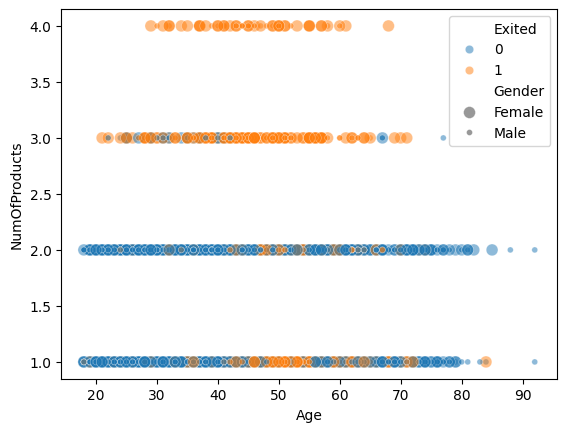

In [5]:
import seaborn as sns

sns.scatterplot(data=df_, x="Age", y="NumOfProducts", hue="Exited", size = "Gender", alpha=0.5)


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mlflow

# préparation des données
X = df_.drop(columns=["Exited"])
y = df_["Exited"]

# Séparation par type de transformations
num_features = ["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]
cat_features = ["Geography","Gender"]
pas_features = ["HasCrCard","IsActiveMember"]

# On resample les donnée pour équilibrer les résultats.
smote = SMOTENC(random_state=42,categorical_features=["Geography","Gender"])
X_resampled, y_resampled = smote.fit_resample(X, y)

#Création du preprocessor pour préparation des données
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop='first'), cat_features),
        ("pas", "passthrough", pas_features)
    ]
)

# MLflow tracking
with mlflow.start_run(run_name="Logistic_Regression_Churn"):
    mlflow.sklearn.autolog()
    model = LogisticRegression(max_iter=1000, C=0.01)

    # Création du pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ]
    )

    # Division Dataset
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42)

    # Fit du model 
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mlflow.log_metric("mse", mse)
    mlflow.sklearn.log_model(pipeline, "model_pipeline")

# Evaluation du model 
score = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

# 13. Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()
# 14. Sauvegarder le modèle
models_storage = {
    "model": pipeline,
    "features" : X_resampled.columns.tolist(),
    "accuracy": score
}

# 15. On récupère le modèle et les features du modèle
model = models_storage["model"]
features = model.named_steps['preprocessor'].get_feature_names_out()

# 16. On récupère les coefficients
importances = model["classifier"].coef_[0]

# 17. Create dataframe sorted by absolute importance
importance_df = pd.DataFrame({
    "features": features,
    "importance": importances
}).sort_values("importance", ascending=True, key=abs)

# 18. Plot the bar chart
plt.figure(figsize=(4,4))
sns.barplot(data=importance_df, y="features", x="importance", hue="importance", legend=False)
plt.title('Importances des features')
plt.xlabel('Importance')
plt.show()

ValueError: could not convert string to float: 'Hargrave'